In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 10

#!pip install https://github.com/Phlya/adjustText/archive/master.zip
from adjustText import adjust_text

#pd.set_option('display.max_rows', None) # don't limit the number of rows in printouts of dataframes
#pd.set_option('display.max_seq_items', None)
#pd.set_option('display.large_repr', 'truncate')


# Read in data and do basic massaging

In [2]:
# Read in the US file
df_us_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
df_us_raw.head(2)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,239,241,248,259,265,272,282,295,312,323
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,292,293,296,304,313,320,325,331,343,353


In [3]:
# Read in the global file
# (Note, the global file includes US, but no state info for the US.  
#  Oddly, the global file has state info for some other countries)
df_global_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_global_raw.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,17267,18054,18969,19551,20342,20917,21459,22142,22890,23546
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,1184,1197,1212,1232,1246,1263,1299,1341,1385,1416


In [4]:
df_global_raw.groupby(['Country/Region']).sum().loc['US',:]

Lat        3.709020e+01
Long      -9.571290e+01
1/22/20    1.000000e+00
1/23/20    1.000000e+00
1/24/20    2.000000e+00
               ...     
6/8/20     1.961621e+06
6/9/20     1.979699e+06
6/10/20    2.000702e+06
6/11/20    2.023590e+06
6/12/20    2.048986e+06
Name: US, Length: 145, dtype: float64

In [5]:
# change the value of 'US' to 'United States'  in df_global_raw so that
# it is different from the df_us_raw file so we don't double count
df_global_raw = df_global_raw.set_index('Country/Region')
as_list = df_global_raw.index.tolist()
idx = as_list.index('US')  # WARNING: this only works because there is only one 'US' in as_list
as_list[idx] = 'United States'
df_global_raw.index = as_list
print(df_global_raw.loc['United States'])
df_global_raw = df_global_raw.reset_index() # after this reset, the country/region column will be called 'index'
df_global_raw.rename(columns={'index': 'Country/Region'}, inplace=True) # reset the name of the newly-restored column to 'Country/Region'

Province/State        NaN
Lat               37.0902
Long             -95.7129
1/22/20                 1
1/23/20                 1
                   ...   
6/8/20            1961621
6/9/20            1979699
6/10/20           2000702
6/11/20           2023590
6/12/20           2048986
Name: United States, Length: 146, dtype: object


In [6]:
# Compare the two sets of columns in preparation for a merger (using append below)
print(df_us_raw.columns)
print(df_global_raw.columns)

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_',
       ...
       '6/3/20', '6/4/20', '6/5/20', '6/6/20', '6/7/20', '6/8/20', '6/9/20',
       '6/10/20', '6/11/20', '6/12/20'],
      dtype='object', length=154)
Index(['Country/Region', 'Province/State', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '6/3/20', '6/4/20', '6/5/20', '6/6/20', '6/7/20', '6/8/20', '6/9/20',
       '6/10/20', '6/11/20', '6/12/20'],
      dtype='object', length=147)


In [7]:
#df_us_raw.Combined_Key.unique()

In [8]:
# Before the merger, add a column for 'Combined_Key'
df_global_raw = df_global_raw.rename(columns={'Province/State': 'Province_State', 
                                             'Country/Region': 'Country_Region',
                                             'Long': 'Long_'})
#df_global_raw['Combined_Key'] = df_global_raw.Province_State.astype(str).str.cat(df_global_raw.Country_Region.astype(str), sep=', ', na_rep='')
df_global_raw.insert(loc=4, column='Combined_Key', value=df_global_raw.Province_State.astype(str).str.cat(df_global_raw.Country_Region.astype(str), sep=', ', na_rep=''))
df_global_raw.head(2)

,Country_Region,Province_State,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20
0,Afghanistan,NaN,33.0000,65.0000,"nan, Afghanistan",0,0,0,0,0,...,17267,18054,18969,19551,20342,20917,21459,22142,22890,23546
1,Albania,NaN,41.1533,20.1683,"nan, Albania",0,0,0,0,0,...,1184,1197,1212,1232,1246,1263,1299,1341,1385,1416


In [9]:
# Merge the us and global tables into df_raw by using append
df_raw = df_global_raw.append(df_us_raw, ignore_index=True, sort=False)
df_raw

,Country_Region,Province_State,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,6/9/20,6/10/20,6/11/20,6/12/20,UID,iso2,iso3,code3,FIPS,Admin2
0,Afghanistan,NaN,33.000000,65.000000,"nan, Afghanistan",0,0,0,0,0,...,21459,22142,22890,23546,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,NaN,41.153300,20.168300,"nan, Albania",0,0,0,0,0,...,1299,1341,1385,1416,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,NaN,28.033900,1.659600,"nan, Algeria",0,0,0,0,0,...,10382,10484,10589,10698,NaN,NaN,NaN,NaN,NaN,NaN
3,Andorra,NaN,42.506300,1.521800,"nan, Andorra",0,0,0,0,0,...,852,852,852,853,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,NaN,-11.202700,17.873900,"nan, Angola",0,0,0,0,0,...,96,113,118,130,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3522,US,Wyoming,41.287818,-110.547578,"Uinta, Wyoming, US",0,0,0,0,0,...,35,39,53,62,84056041.0,US,USA,840.0,56041.0,Uinta
3523,US,Wyoming,43.904516,-107.680187,"Washakie, Wyoming, US",0,0,0,0,0,...,39,39,39,39,84056043.0,US,USA,840.0,56043.0,Washakie
3524,US,Wyoming,43.839612,-104.567488,"Weston, Wyoming, US",0,0,0,0,0,...,1,1,1,1,84056045.0,US,USA,840.0,56045.0,Weston
3525,US,Wyoming,0.000000,0.000000,"Out of WY, Wyoming, US",0,0,0,0,0,...,0,0,0,0,84080056.0,US,USA,840.0,80056.0,Out of WY


In [10]:
df_raw.Country_Region.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

In [11]:
df_raw = df_raw.drop(labels=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2'], axis=1)

In [12]:
df_raw.columns

Index(['Country_Region', 'Province_State', 'Lat', 'Long_', 'Combined_Key',
       '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20',
       ...
       '6/3/20', '6/4/20', '6/5/20', '6/6/20', '6/7/20', '6/8/20', '6/9/20',
       '6/10/20', '6/11/20', '6/12/20'],
      dtype='object', length=148)

In [13]:
# The steps above should have positioned the most recent date to be
# the last column.
# Using that, list the countries in sorted order of most confirmed cases
# on the most recent date
tempdf = df_raw.groupby('Country_Region').sum()
tempdf.sort_values(by=tempdf.columns[-1]).iloc[:,[-1]].tail(15)

,6/12/20
Country_Region,
Mexico,139196
Chile,160846
Turkey,175218
Iran,182525
Germany,187226
France,193220
Peru,214788
Italy,236305
Spain,243209


In [14]:
# Re-shape the data so dates are used as the indexes and we have a row for
# every country/date.
df1 = df_raw.melt(id_vars=df_raw.columns[:5], var_name='Date', value_name='Confirmed')
df1 = df1.set_index('Date')
df1

,Country_Region,Province_State,Lat,Long_,Combined_Key,Confirmed
Date,,,,,,
1/22/20,Afghanistan,NaN,33.000000,65.000000,"nan, Afghanistan",0
1/22/20,Albania,NaN,41.153300,20.168300,"nan, Albania",0
1/22/20,Algeria,NaN,28.033900,1.659600,"nan, Algeria",0
1/22/20,Andorra,NaN,42.506300,1.521800,"nan, Andorra",0
1/22/20,Angola,NaN,-11.202700,17.873900,"nan, Angola",0
...,...,...,...,...,...,...
6/12/20,US,Wyoming,41.287818,-110.547578,"Uinta, Wyoming, US",62
6/12/20,US,Wyoming,43.904516,-107.680187,"Washakie, Wyoming, US",39
6/12/20,US,Wyoming,43.839612,-104.567488,"Weston, Wyoming, US",1


In [15]:
# Alternative reshape where only Combined_Key is used
df2 = df_raw.melt(id_vars='Combined_Key', value_vars=df_raw.columns[5:], var_name='Date', value_name='Confirmed')
df2['Date'] = pd.to_datetime(df2.Date)
df2 = df2.set_index('Date')
df2

,Combined_Key,Confirmed
Date,,
2020-01-22,"nan, Afghanistan",0
2020-01-22,"nan, Albania",0
2020-01-22,"nan, Algeria",0
2020-01-22,"nan, Andorra",0
2020-01-22,"nan, Angola",0
...,...,...
2020-06-12,"Uinta, Wyoming, US",62
2020-06-12,"Washakie, Wyoming, US",39
2020-06-12,"Weston, Wyoming, US",1


# Narrow down to a set of interesting States and Counties and graph

In [16]:
# just a cell to try different approaches for choosing rows
rowsofinterest = df2['Combined_Key'].isin(['Santa Clara, California, US', 'New York City, New York, US', 'Salt Lake, Utah, US'])
rowsofinterest = df2['Combined_Key'].str.endswith('California, US')
df2.loc[rowsofinterest,:]

,Combined_Key,Confirmed
Date,,
2020-01-22,"Alameda, California, US",0
2020-01-22,"Alpine, California, US",0
2020-01-22,"Amador, California, US",0
2020-01-22,"Butte, California, US",0
2020-01-22,"Calaveras, California, US",0
...,...,...
2020-06-12,"Ventura, California, US",1518
2020-06-12,"Yolo, California, US",240
2020-06-12,"Yuba, California, US",34


In [17]:
# Here is the main approach we'll use for areas of interest
df = pd.DataFrame(index = df2.index.unique(),
                     data = {
                         'California': df2.loc[df2['Combined_Key'].str.endswith('California, US'),'Confirmed'].groupby(level=0).sum(),
                         'New York': df2.loc[df2['Combined_Key'].str.endswith('New York, US'),'Confirmed'].groupby(level=0).sum(),
                         'Washington': df2.loc[df2['Combined_Key'].str.endswith('Washington, US'),'Confirmed'].groupby(level=0).sum(),
                         'Utah': df2.loc[df2['Combined_Key'].str.endswith('Utah, US'),'Confirmed'].groupby(level=0).sum(),
                         'Hawaii': df2.loc[df2['Combined_Key'].str.endswith('Hawaii, US'),'Confirmed'].groupby(level=0).sum(),
                         'Idaho': df2.loc[df2['Combined_Key'].str.endswith('Idaho, US'),'Confirmed'].groupby(level=0).sum(),
                         'Texas': df2.loc[df2['Combined_Key'].str.endswith('Texas, US'),'Confirmed'].groupby(level=0).sum(),
                         'Santa Clara Co.': df2.loc[df2['Combined_Key']=='Santa Clara, California, US', 'Confirmed'].groupby(level=0).sum(),
                         'Los Angeles Co.': df2.loc[df2['Combined_Key']=='Los Angeles, California, US', 'Confirmed'].groupby(level=0).sum(),
                         'Japan': df2.loc[df2['Combined_Key'].str.endswith('Japan'),'Confirmed'].groupby(level=0).sum(),
                         # note that in the following, we are using 'United States' which is the renamed country
                         # value from the global file so that we don't double count
                         'United States': df2.loc[df2['Combined_Key'].str.endswith('United States'),'Confirmed'].groupby(level=0).sum(),
                         'Singapore': df2.loc[df2['Combined_Key'].str.endswith('Singapore'),'Confirmed'].groupby(level=0).sum(),
                         'Italy': df2.loc[df2['Combined_Key'].str.endswith('Italy'),'Confirmed'].groupby(level=0).sum(),
                         'Spain': df2.loc[df2['Combined_Key'].str.endswith('Spain'),'Confirmed'].groupby(level=0).sum(),
                         'Iran': df2.loc[df2['Combined_Key'].str.endswith('Iran'),'Confirmed'].groupby(level=0).sum(),
                         'France': df2.loc[df2['Combined_Key'].str.endswith('France'),'Confirmed'].groupby(level=0).sum(),
                         'Germany': df2.loc[df2['Combined_Key'].str.endswith('Germany'),'Confirmed'].groupby(level=0).sum(),
                         'Switzerland': df2.loc[df2['Combined_Key'].str.endswith('Switzerland'),'Confirmed'].groupby(level=0).sum(),
                         'United Kingdom': df2.loc[df2['Combined_Key'].str.endswith('United Kingdom'),'Confirmed'].groupby(level=0).sum(),
                         'South Korea': df2.loc[df2['Combined_Key'].str.endswith('Korea, South'),'Confirmed'].groupby(level=0).sum(),
       #                  'Taiwan': df2.loc[df2['Combined_Key'].str.endswith('Taiwan*'),'Confirmed'].groupby(level=0).sum(),
       #                  'Philippines': df2.loc[df2['Combined_Key'].str.endswith('Philippines'),'Confirmed'].groupby(level=0).sum(),
       #                  'Ireland': df2.loc[df2['Combined_Key'].str.endswith('Ireland'),'Confirmed'].groupby(level=0).sum(),
                         'China': df2.loc[df2['Combined_Key'].str.endswith('China'),'Confirmed'].groupby(level=0).sum(),
                         'Turkey': df2.loc[df2['Combined_Key'].str.endswith('Turkey'),'Confirmed'].groupby(level=0).sum(),
       #                  'Belgium': df2.loc[df2['Combined_Key'].str.endswith('Belgium'),'Confirmed'].groupby(level=0).sum(),
       #                  'Netherlands': df2.loc[df2['Combined_Key'].str.endswith('Netherlands'),'Confirmed'].groupby(level=0).sum(),
                         'Canada': df2.loc[df2['Combined_Key'].str.endswith('Canada'),'Confirmed'].groupby(level=0).sum(),
                         'Brazil': df2.loc[df2['Combined_Key'].str.endswith('Brazil'),'Confirmed'].groupby(level=0).sum(),
                         'Russia': df2.loc[df2['Combined_Key'].str.endswith('Russia'),'Confirmed'].groupby(level=0).sum(),
                         'India': df2.loc[df2['Combined_Key'].str.endswith('India'),'Confirmed'].groupby(level=0).sum(),
                     }

)
df = df.loc[~(df==0).all(axis=1)] # drop rows with all zeros
# The next two drops ensure that if the two source files are out of sync, we don't
# show the rows where there is zero data for one of them
df = df.loc[~(df['Italy']==0)] # drop rows if Italy is Zero (from global source)
df = df.loc[~(df['California']==0)] # drop rows if California is Zero (from US source)
df = df.loc['2/1/20':,:]
df

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Los Angeles Co.,Japan,...,Germany,Switzerland,United Kingdom,South Korea,China,Turkey,Canada,Brazil,Russia,India
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,3,0,1,0,0,0,0,1,1,20,...,8,0,2,12,11891,0,4,0,2,1
2020-02-02,3,0,1,0,0,0,0,1,1,20,...,10,0,2,15,16630,0,4,0,2,2
2020-02-03,6,0,1,0,0,0,0,2,1,20,...,12,0,2,15,19716,0,4,0,2,3
2020-02-04,6,0,1,0,0,0,0,2,1,22,...,12,0,2,16,23707,0,4,0,2,3
2020-02-05,6,0,1,0,0,0,0,2,1,22,...,12,0,2,19,27440,0,5,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-08,133816,378799,24041,12322,676,3189,76463,2973,64690,17060,...,186109,30972,288834,11852,84195,171121,97779,707412,476043,265928
2020-06-09,136641,379482,24354,12559,682,3221,78208,3017,65945,17111,...,186506,30988,290581,11902,84198,172114,98241,739503,484630,276146
2020-06-10,139715,380156,24354,12864,685,3260,80777,3032,67111,17146,...,186522,31011,291588,11947,84209,173036,98720,772416,493023,286605


In [18]:
df['United States']

Date
2020-02-01          8
2020-02-02          8
2020-02-03         11
2020-02-04         11
2020-02-05         11
               ...   
2020-06-08    1961621
2020-06-09    1979699
2020-06-10    2000702
2020-06-11    2023590
2020-06-12    2048986
Name: United States, Length: 133, dtype: int64

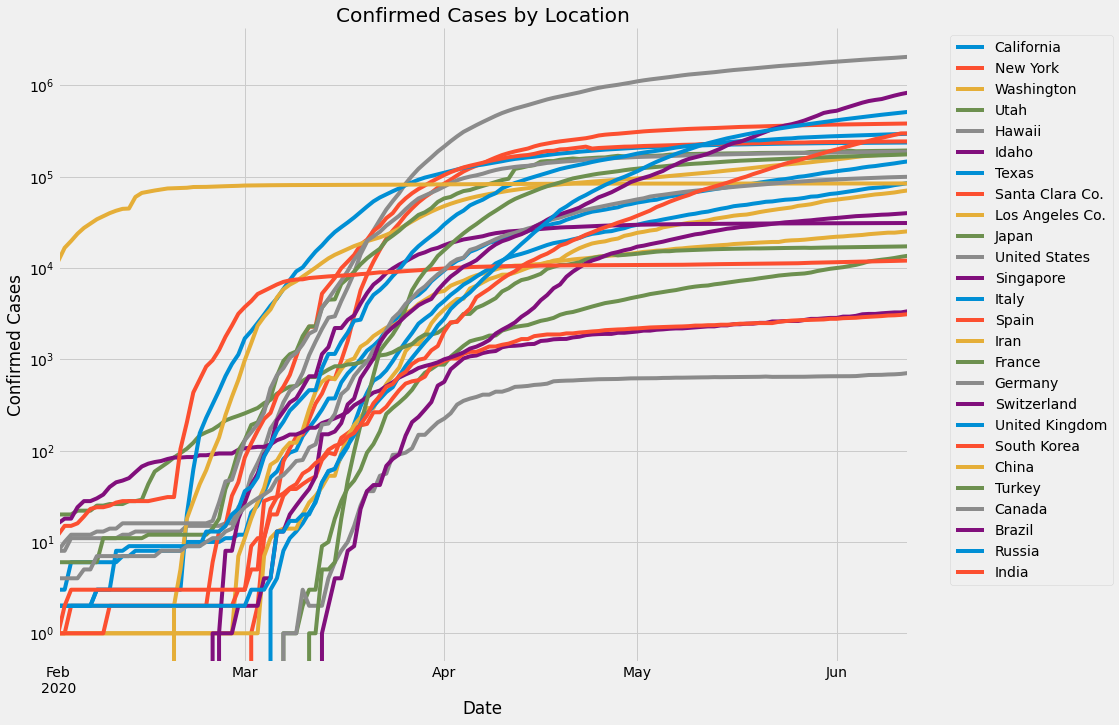

In [19]:
#newdf.loc['2/1/20':,:].plot(logy=True)
df.plot(logy=True)
plt.legend(bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.title("Confirmed Cases by Location")
plt.ylabel("Confirmed Cases")
sns.despine()

# TEMP ONLY
Drop rows that have data glitches

In [20]:
#df = df.drop(labels=['3/22/20', '3/30/20'], axis=0)

# Graph raw data

### label_lines routine

In [21]:
def label_lines(df, ax, tuple_selector=None, print_value=False, adjust=False, font_family='sans-serif', font_size=14):
    '''Labels lines in a chart assuming that some lines will be different lengths than others
       If tuple_selector is set to an integer, use it as an index to the label'''
    texts = []
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    for label, series in df.items():
        prev_x = series.index[0]
        prev_data = series.iloc[0]
        for index, data in series.items(): # loop forward to the last item in the line
            if pd.isnull(data):
                break
            if (data < maxy): # stop incrementing prev_x if data is above y axis already
                prev_x = index   # this will be the last x index still on the chart for that line
            prev_data = data # this will be the last y point with data
        if not (tuple_selector is None):
            if print_value:
                label = '{} ({:,})'.format(label[tuple_selector], int(prev_data))
            else:
                label = label[tuple_selector]
        else:
            if print_value:
                label = '{} ({:,})'.format(label, int(prev_data))
        #if(prev_x > maxx): prev_x = maxx   # data types don't always match
        if(prev_data > maxy): prev_data = (maxy - ((maxy-miny)*0.05)) # down 5% from max y location
        this_annotation = ax.annotate(label, (prev_x, prev_data),
                            xytext=(10,0), 
                            textcoords='offset pixels',
                            family=font_family, fontsize=font_size, color='darkslategrey')
        texts.append(this_annotation)
        if(adjust):
            adjust_text(texts)

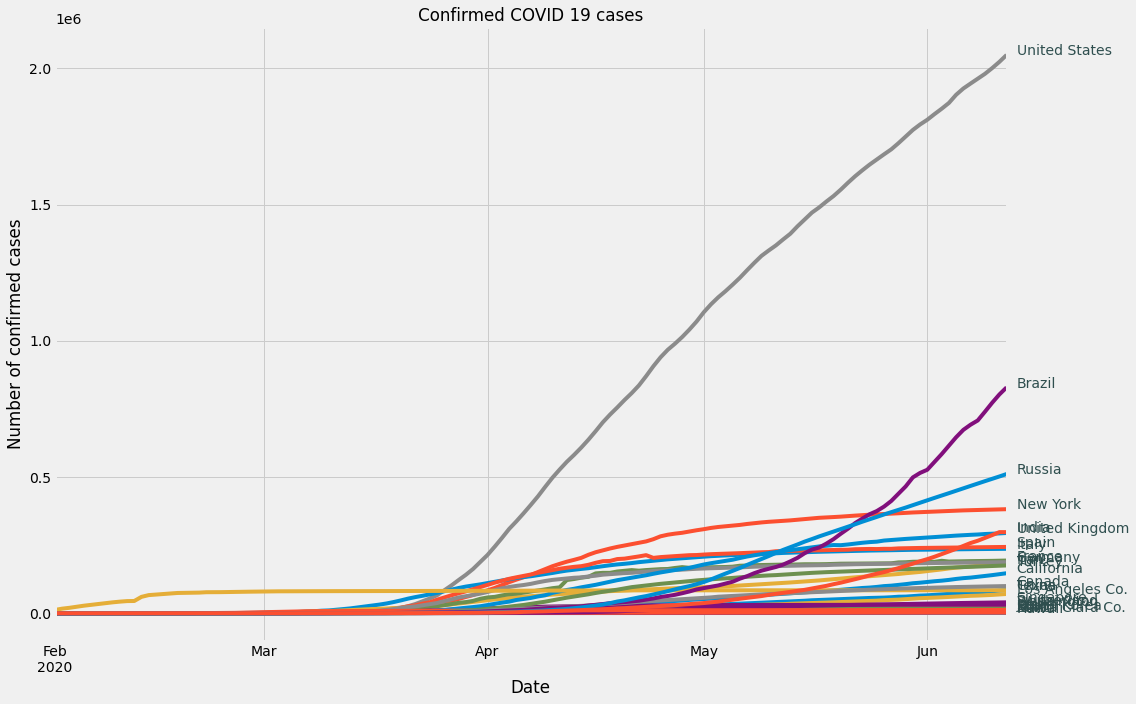

In [22]:
  
graph_data = df.loc['2020-02':,:]
#graph_data = df.drop('China', axis=1).loc['2/21/20':,:]
ax = graph_data.plot(legend=False)
ax.set_title('Confirmed COVID 19 cases', fontsize='large')
ax.set_ylabel('Number of confirmed cases', fontsize='large')
label_lines(graph_data, ax)
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig('raw.png')

# Create a 'days since 100 cases' graph

In [23]:
df.tail(2)

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Los Angeles Co.,Japan,...,Germany,Switzerland,United Kingdom,South Korea,China,Turkey,Canada,Brazil,Russia,India
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-11,143377,380892,24779,13252,692,3260,82658,3063,68959,17187,...,186691,31044,292860,12003,84216,174023,99159,802828,501800,297535
2020-06-12,146659,381714,25171,13577,706,3353,84927,3117,70529,17250,...,187226,31063,294402,12051,84228,175218,99595,828810,510761,297535


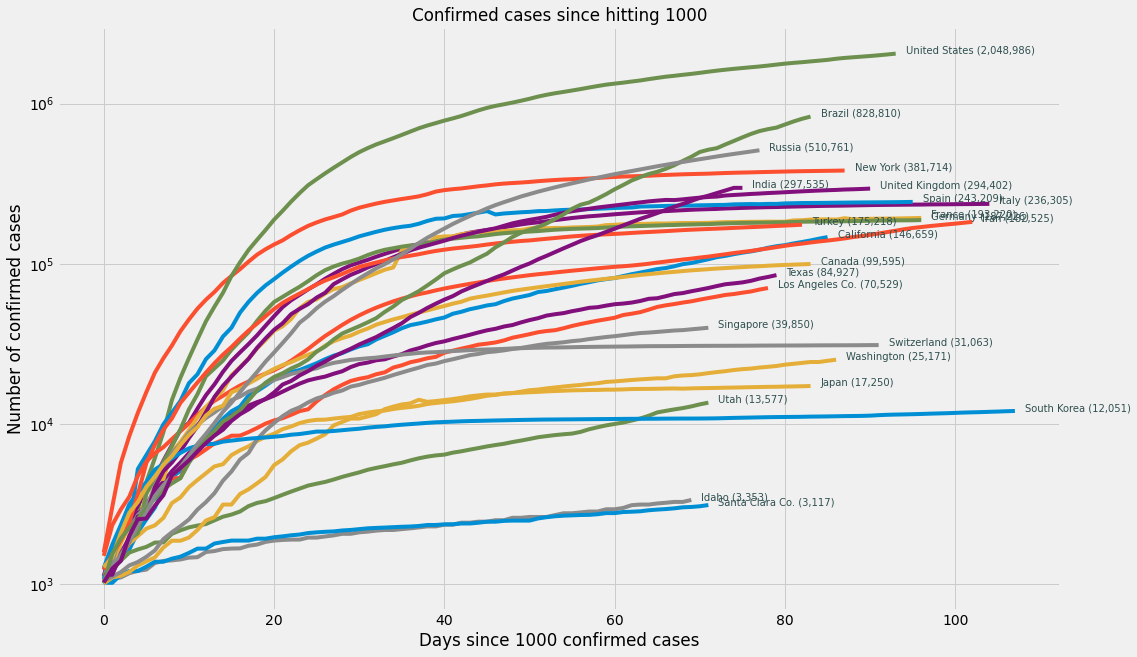

In [24]:
threshold = 1000
daysSince100 = pd.DataFrame(index=range(0,len(df.index)))
for location in df.columns:
    # create list of data once above 'threshold'
    tempList = [df.loc[date, location] 
                              for date in df[location].index 
                              if df.loc[date, location] > threshold]
    if (not tempList) or (tempList[-1] <= threshold):
        continue
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSince100.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSince100[location] = tempListFilled

daysSince100 = daysSince100.drop('China', axis=1)
daysSince100 = daysSince100.dropna(axis=0, how='all')
ax = daysSince100.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Confirmed cases since hitting {}'.format(threshold), fontsize='large')
ax.set_xlabel('Days since {} confirmed cases'.format(threshold), fontsize='large')
ax.set_ylabel('Number of confirmed cases', fontsize='large')
#ax.annotate("Italy on 3/14", xy=(20,21157), xytext=(15, 30000),
#            arrowprops=dict(facecolor='grey', shrink=0.05),)

label_lines(daysSince100, ax, print_value=True, font_size=10)
    
#ax.hlines(60461826, 0, 50, linestyles='dotted', label='Pop of Italy')
plt.show()
fig = ax.get_figure()
fig.savefig('since100.png')

# Cases relative to Population

In [25]:
per = 100000

popdf = pd.DataFrame(index = df.index,
                     data = {
                         'California': 39747267,
                         'New York': 19491339,
                         'Washington': 7797095,
                         'Utah': 3282115,
                         'Hawaii': 1412687,
                         'Idaho': 1826156,
                         'Texas': 29472295,
                         'Santa Clara Co.': 2200000,
                         'Los Angeles Co.': 10500000,
                         'Japan': 126476461,
                         'United States': 331002651,
                         'Singapore': 5850342,
                         'Italy': 60461826,
                         'Spain': 46754778,
                         'Iran': 83992949,
                         'France': 65273511,
                         'Germany': 83783942,
                         'Switzerland': 8654622,
                         'United Kingdom': 67886011,
                         'South Korea': 51269185,
                         'Taiwan': 23816775,
                         'Philippines': 109581078,
                         'Ireland': 4937786,
                         'China': 1439323776,
                         'Turkey': 84339067,
                         'Belgium': 11589623,
                         'Netherlands': 17134872,
                         'Canada': 37742154,
                         'Brazil': 212559417,
                         'India': 1380004385,
                         'Indonesia': 273523615,
                         'Pakistan': 220892340,
                         'Nigeria': 206139589,
                         'Russia': 145934462,
                         
                     }

)
popdf

casesperdf = df.div(popdf).mul(per)
casesperdf.tail()

,Belgium,Brazil,California,Canada,China,France,Germany,Hawaii,Idaho,India,...,South Korea,Spain,Switzerland,Taiwan,Texas,Turkey,United Kingdom,United States,Utah,Washington
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-08,NaN,332.806709,336.667173,259.071064,5.849622,293.094392,222.129677,47.852072,174.629112,19.270084,...,23.117200,516.988873,357.866583,NaN,259.440264,202.896482,425.469100,592.629997,375.428649,308.332783
2020-06-09,NaN,347.904134,343.774580,260.295160,5.849830,293.416115,222.603515,48.276795,176.381426,20.010516,...,23.214724,517.521439,358.051455,NaN,265.361079,204.073872,428.042531,598.091584,382.649602,312.347099
2020-06-10,NaN,363.388276,351.508445,261.564298,5.850595,294.251063,222.622612,48.489156,178.517060,20.768412,...,23.302496,518.193028,358.317209,NaN,274.077740,205.167079,429.525900,604.436851,391.942391,312.347099
2020-06-11,NaN,377.695804,360.721657,262.727453,5.851081,294.902169,222.824321,48.984665,178.517060,21.560439,...,23.411724,519.106304,358.698508,NaN,280.460005,206.337355,431.399630,611.351599,403.764036,317.797847
2020-06-12,NaN,389.919210,368.978828,263.882660,5.851915,296.015944,223.462868,49.975685,183.609724,21.560439,...,23.505347,520.179991,358.918044,NaN,288.158761,207.754255,433.671084,619.024045,413.666188,322.825360


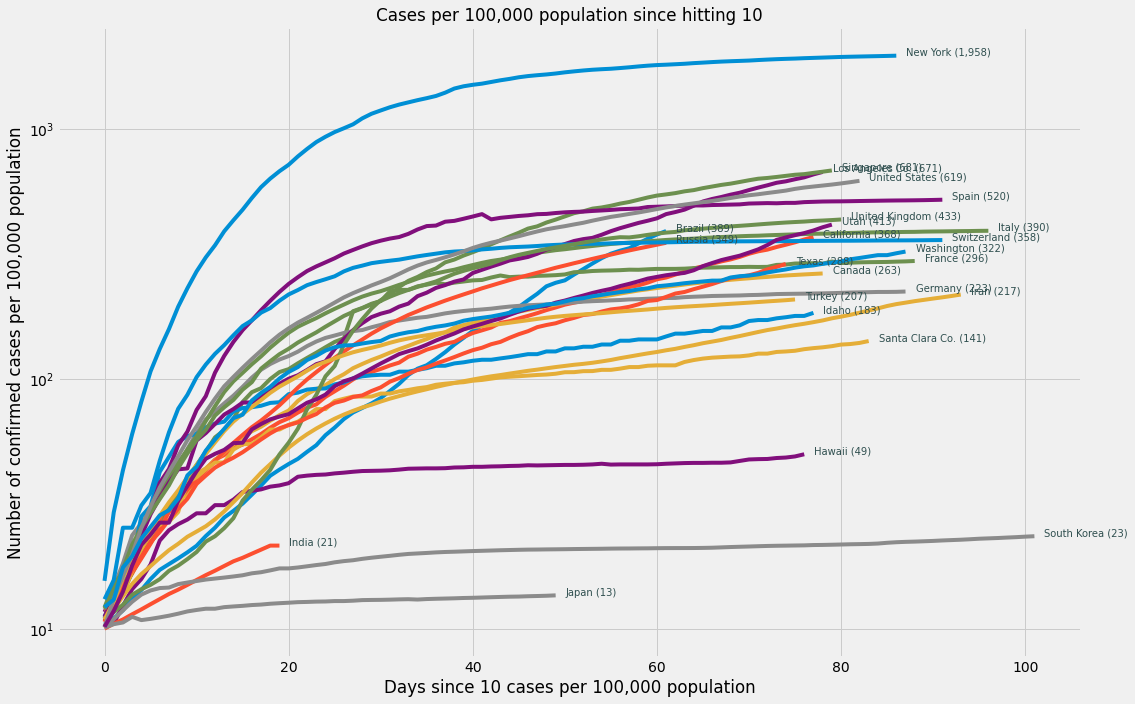

In [26]:
threshold = 10
daysSincerate = pd.DataFrame(index=range(0,len(casesperdf.index)))
for location in casesperdf.columns:
    # create list of data once above 'threshold'
    tempList = [casesperdf.loc[date, location] 
                              for date in casesperdf[location].index 
                              if casesperdf.loc[date, location] > threshold]
    if (not tempList) or (tempList[-1] <= threshold):
        continue
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSincerate.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSincerate[location] = tempListFilled


#daysSincerate = daysSincerate.drop(['China','Singapore'], axis=1)
daysSincerate = daysSincerate.dropna(axis=0, how='all')
ax = daysSincerate.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Cases per {:,} population since hitting {}'.format(per, threshold), fontsize='large')
ax.set_xlabel('Days since {} cases per {:,} population'.format(threshold, per), fontsize='large')
ax.set_ylabel('Number of confirmed cases per {:,} population'.format(per), fontsize='large')
#ax.annotate("Italy on 3/14", xy=(16,34.99), xytext=(25, 24),
#            arrowprops=dict(facecolor='grey', shrink=0.05),)

label_lines(daysSincerate, ax, print_value=True, font_size=10)

plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig('pop-adjusted.png')

In [27]:
daysSincerate

,Brazil,California,Canada,France,Germany,Hawaii,Idaho,India,Iran,Italy,...,Singapore,South Korea,Spain,Switzerland,Texas,Turkey,United Kingdom,United States,Utah,Washington
0,10.440375,11.716529,10.709511,10.238456,11.048657,10.547276,11.225766,10.038809,10.715185,12.197779,...,10.785694,10.115238,11.190300,13.160598,10.677825,10.928506,12.026042,10.169103,10.206833,12.248151
1,11.022800,12.818491,12.405227,11.819496,14.712843,10.547276,12.813801,10.503590,11.995054,15.169902,...,11.674531,10.963701,13.669191,15.702592,12.924002,12.837467,14.200275,13.208353,11.821645,13.107446
2,11.884677,14.723025,14.773932,13.978105,18.285127,12.387741,15.387513,10.926994,13.529707,16.785798,...,12.512089,11.874579,16.678509,25.419943,14.776589,16.043573,17.399756,16.301682,14.106757,17.621948
3,13.323333,17.958467,16.639220,16.806205,23.689504,14.440566,18.618344,11.455471,15.154844,20.611352,...,13.708600,12.859576,21.264137,25.419943,17.199204,18.590436,21.720233,19.900747,17.945745,19.545741
4,14.313645,20.655508,19.601425,19.545448,26.512240,15.856308,28.201315,11.984455,16.594250,24.995937,...,14.426507,13.733396,25.126844,31.197203,19.455560,21.502491,25.501572,25.345114,21.693329,22.995744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,23.117200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,23.214724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,23.302496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,23.411724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Look at growth factor changes

In [28]:
start_date = '3/22/20'
location = ['California', 'Italy', 'New York']
#location = ['California', 'South Korea', 'Italy', 'Germany', 'New York']
df.loc[start_date:,:]

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Los Angeles Co.,Japan,...,Germany,Switzerland,United Kingdom,South Korea,China,Turkey,Canada,Brazil,Russia,India
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,1646,15800,1997,162,53,42,643,263,407,1101,...,24873,7474,5745,8961,81435,1236,1469,1546,367,396
2020-03-23,2108,20884,2221,252,56,68,758,302,536,1128,...,29056,8795,6726,8961,81498,1529,2088,1924,438,499
2020-03-24,2538,25681,2328,293,90,81,955,375,662,1193,...,32986,9877,8164,9037,81591,1872,2790,2247,495,536
2020-03-25,2998,30841,2591,335,91,91,1229,459,812,1307,...,37323,10897,9640,9137,81661,2433,3251,2554,658,657
2020-03-26,3899,37877,3207,388,95,146,1563,542,1229,1387,...,43938,11811,11812,9241,81782,3629,4042,2985,840,727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-08,133816,378799,24041,12322,676,3189,76463,2973,64690,17060,...,186109,30972,288834,11852,84195,171121,97779,707412,476043,265928
2020-06-09,136641,379482,24354,12559,682,3221,78208,3017,65945,17111,...,186506,30988,290581,11902,84198,172114,98241,739503,484630,276146
2020-06-10,139715,380156,24354,12864,685,3260,80777,3032,67111,17146,...,186522,31011,291588,11947,84209,173036,98720,772416,493023,286605


In [29]:
# calculate growth factor (diff between 2 points divided by the diff between the prior 2 points)
df.loc[start_date:,:].diff().pct_change().add(1)

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Los Angeles Co.,Japan,...,Germany,Switzerland,United Kingdom,South Korea,China,Turkey,Canada,Brazil,Russia,India
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-24,0.930736,0.943548,0.477679,0.455556,11.333333,0.500000,1.713043,1.871795,0.976744,2.407407,...,0.939517,0.819076,1.465851,inf,1.476190,1.170648,1.134087,0.854497,0.802817,0.359223
2020-03-25,1.069767,1.075672,2.457944,1.024390,0.029412,0.769231,1.390863,1.150685,1.190476,1.753846,...,1.103562,0.942699,1.026426,1.315789,0.752688,1.635569,0.656695,0.950464,2.859649,3.270270
2020-03-26,1.958696,1.363566,2.342205,1.261905,4.000000,5.500000,1.218978,0.988095,2.780000,0.701754,...,1.525248,0.896078,1.471545,1.040000,1.728571,2.131907,1.715835,1.403909,1.116564,0.578512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-08,1.583086,0.898848,1.087108,0.955224,0.500000,inf,1.124733,1.409091,0.578659,0.538462,...,1.196667,0.777778,0.914092,1.000000,0.800000,1.082057,0.854908,0.827728,0.999889,0.777062
2020-06-09,0.882537,0.972934,1.003205,0.925781,6.000000,0.640000,1.654028,1.419355,1.483452,2.428571,...,1.105850,2.285714,1.440231,1.315789,0.750000,1.004044,0.768719,2.050019,0.957302,1.210377
2020-06-10,1.088142,0.986823,0.000000,1.286920,0.500000,1.218750,1.472206,0.340909,0.929084,0.686275,...,0.040302,1.437500,0.576417,0.900000,3.666667,0.928499,1.036797,1.025615,0.977408,1.023586


In [30]:
# Many countries didn't update their reports on 3/12 leading to 'inf' growth
# factor on 3/13.  I'm going to drop 3/12 data to get a better trend
#tempdf = df.drop('3/12/20', axis='index')
tempdf = df
tempdf.loc[start_date:,:].diff().pct_change().add(1)

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Los Angeles Co.,Japan,...,Germany,Switzerland,United Kingdom,South Korea,China,Turkey,Canada,Brazil,Russia,India
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-24,0.930736,0.943548,0.477679,0.455556,11.333333,0.500000,1.713043,1.871795,0.976744,2.407407,...,0.939517,0.819076,1.465851,inf,1.476190,1.170648,1.134087,0.854497,0.802817,0.359223
2020-03-25,1.069767,1.075672,2.457944,1.024390,0.029412,0.769231,1.390863,1.150685,1.190476,1.753846,...,1.103562,0.942699,1.026426,1.315789,0.752688,1.635569,0.656695,0.950464,2.859649,3.270270
2020-03-26,1.958696,1.363566,2.342205,1.261905,4.000000,5.500000,1.218978,0.988095,2.780000,0.701754,...,1.525248,0.896078,1.471545,1.040000,1.728571,2.131907,1.715835,1.403909,1.116564,0.578512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-08,1.583086,0.898848,1.087108,0.955224,0.500000,inf,1.124733,1.409091,0.578659,0.538462,...,1.196667,0.777778,0.914092,1.000000,0.800000,1.082057,0.854908,0.827728,0.999889,0.777062
2020-06-09,0.882537,0.972934,1.003205,0.925781,6.000000,0.640000,1.654028,1.419355,1.483452,2.428571,...,1.105850,2.285714,1.440231,1.315789,0.750000,1.004044,0.768719,2.050019,0.957302,1.210377
2020-06-10,1.088142,0.986823,0.000000,1.286920,0.500000,1.218750,1.472206,0.340909,0.929084,0.686275,...,0.040302,1.437500,0.576417,0.900000,3.666667,0.928499,1.036797,1.025615,0.977408,1.023586


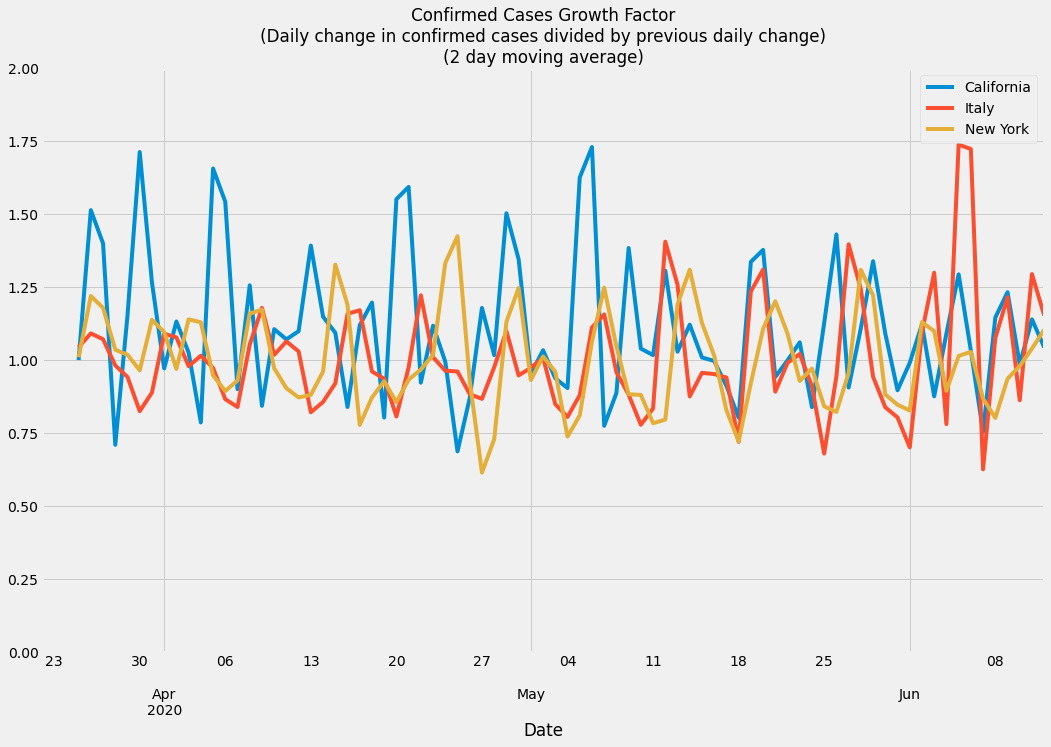

In [31]:
# graph the growth factors
window = 2
ax = tempdf.loc[start_date:,location].diff().pct_change().add(1).rolling(window).mean().plot()
ax.set_ylim(ymin=0, ymax=2)
ax.set_title("Confirmed Cases Growth Factor\n(Daily change in confirmed cases divided by previous daily change)\n({} day moving average)".format(window), fontsize='large')
fig = ax.get_figure()
fig.savefig('growth_factors.png')